In [1]:
n_items = 1500

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import psutil


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, RandomRec, LinUCB, LinTS
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.dataset_bootstrap import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

from modified_ips import Exp_Smooth_IPS_Min, Exp_Smooth_IPS_Max

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [5]:
print('momory usage:', psutil.virtual_memory().percent)

momory usage: 10.2


In [6]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/10/07 09:37:28 WARN Utils: Your hostname, hdilab-hdilabALIEN05 resolves to a loopback address: 127.0.1.1; using 172.21.136.110 instead (on interface enp3s0)
24/10/07 09:37:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/07 09:37:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/07 09:37:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [7]:
ci = np.load('./Vs_CIs/CIs_1_opt_300.npy', allow_pickle=True)

Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [8]:
from rs_datasets import MovieLens

data = MovieLens("1m")

Оставим только 300 самых популярных айтемов

In [9]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['item_id', 'cnt']].groupby(by=["item_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
popular_items = logs.iloc[:n_items]['item_id'].tolist()
# popular_items = logs['item_id'].tolist()

In [ ]:
data.ratings = data.ratings[data.ratings['item_id'].isin(popular_items)]
print('размер датасета логов после выброса непопулярных айтемов:', data.ratings.shape)

размер датасета логов после выброса непопулярных айтемов: (869950, 5)


Оставим информацию только о фичах юзеров и айтемов которые остались в логах

In [ ]:
data.items = data.items[data.items['item_id'].isin(popular_items)]
users = set(data.ratings['user_id'].tolist())
data.users = data.users[data.users['user_id'].isin(users)]
data.users.shape, data.items.shape

((6040, 5), (1500, 3))

In [12]:
a = np.load('./models/pscores_0.npy')
b = np.load('./models/pscores_1.npy')

In [ ]:
np.sum((a - b)**2)

0.02431339668333185

In [14]:
dataset = MovielensBanditDataset(data, -1)

07-Oct-24 09:37:30, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


07-Oct-24 09:37:36, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:37:37, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model -1


In [15]:
def optimize_ope_parameters(learner_action_dist, lambda_s, beta_1s, beta_2s, k=20000):
    CIPS_MSE = []
    for lambda_ in lambda_s:
        ope = InverseProbabilityWeighting(lambda_=lambda_, estimator_name='cips')
        CIPS_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(CIPS_MSE))
        best_lambda_ = lambda_s[best_idx]
        # print(np.array(CIPS_MSE)[best_idx])
        
    
    ESIPSMAX_MSE = []
    for beta_1 in beta_1s:
        ope = Exp_Smooth_IPS_Max(beta = beta_1)
        ESIPSMAX_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(ESIPSMAX_MSE))
        best_beta_1 = beta_1s[best_idx]
        # print(np.array(ESIPSMAX_MSE)[best_idx])
        
    ESIPSMAX_MSE = []
    for beta_2 in beta_2s:
        ope = Exp_Smooth_IPS_Max(beta = beta_2)
        ESIPSMAX_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(ESIPSMAX_MSE))
        best_beta_2 = beta_2s[best_idx]
        # print(np.array(ESIPSMAX_MSE)[best_idx])
        
    return {'lambda_':best_lambda_, 'beta_1': best_beta_1, 'beta_2': best_beta_2}

In [16]:
dict_opt_algo = {    
    'UCB': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'LinUCB': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'Random': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'LinTS': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
}

In [17]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], bandit_feedback_test["n_actions"], 1))
    if isinstance(learner.replay_model, (LinUCB, LinTS)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for batch_idx in tqdm(range(num_batchs+1)):
            j = min((batch_idx+1)*batch_size, log_distinct.shape[0])
            if j == batch_idx*batch_size:
                break
            log_subset = log_distinct.iloc[batch_idx*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for batch_idx in tqdm(range(num_batchs+1)):
            j = min((batch_idx+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == batch_idx*batch_size:
                break
            bandit_feedback_subset = bandit_subset([batch_idx*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[batch_idx*batch_size:j] = action_dist
    return all_action_dist

In [18]:
import warnings
warnings.filterwarnings("ignore")

Подсчет Vs, CIs для разного числа негативных семплов для LinUCB:

In [19]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)
print('train_size:', bandit_feedback_train["n_rounds"])
print('test_size:', bandit_feedback_test["n_rounds"])

train_size: 608965
test_size: 260985


In [20]:
# estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
#                                                         dataset.len_list,
#                                                         bandit_feedback_train,
#                                                         bandit_feedback_test)

# np.save(f'estimated_rewards_by_reg_model_{n_items}.npy', estimated_rewards_by_reg_model)
estimated_rewards_by_reg_model = np.load(f'estimated_rewards_by_reg_model_{n_items}.npy')

In [ ]:
print('momory usage:', psutil.virtual_memory().percent)

momory usage: 28.5


In [22]:
param_borders_1 = {
    "coef": [0, 10],
}
param_borders_2 = {
    "eps": [-10, 10],
    "alpha": [0.001, 10]
}
param_borders_3 = {
    "distribution": ["popular_based", "relevance"],
    "alpha": [-0.5, 1000],
}
param_borders_4 = {
    "nu": [0.001, 10],
    "alpha": [100, 1500]
}

model_1 = UCB(exploration_coef = 0.018256352926343977, sample = True, seed = 123)
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1)

model_2 = LinUCB(eps = -9.99673647896505, alpha = 0.01558082488570561, regr_type = 'disjoint')
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2)

model_3 = RandomRec(distribution = 'relevance', alpha = 153.974492960275, seed=42)
learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3)

model_4 = LinTS(nu = 9.585195706830213, alpha = 140.03084149742904, regr_type = 'disjoint')
learner_4 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_4)

UCB:

In [23]:
# print('momory usage:', psutil.virtual_memory().percent)

# learner_1.fit(bandit_feedback_train)

# learner_action_dist_1 = get_dist(learner_1)

# opt_params_ips_1 = optimize_ope_parameters(learner_action_dist_1, dict_opt_algo['UCB']['lambda_s'], dict_opt_algo['UCB']['beta_1s'], dict_opt_algo['UCB']['beta_2s'])
# print(opt_params_ips_1)

# print('momory usage:', psutil.virtual_memory().percent)

In [24]:
# np.save(f'./models/learner_action_dist_1.npy', learner_action_dist_1)

In [25]:
# learner_action_dist_1 = np.load(f'./models/learner_action_dist_1.npy')

In [26]:
print('momory usage:', psutil.virtual_memory().percent)

momory usage: 28.6


In [27]:
bandit_feedback_test

{'log': DataFrame[user_idx: int, item_idx: int, relevance: bigint, timestamp: timestamp, cnt: bigint, pscore: double],
 'item_features': DataFrame[item_idx: int, Documentary: int, Fantasy: int, Adventure: int, War: int, Animation: int, Comedy: int, Thriller: int, Film-Noir: int, Crime: int, Sci-Fi: int, Musical: int, Mystery: int, Children's: int, Drama: int, Horror: int, Romance: int, Action: int, Western: int],
 'user_features': DataFrame[user_idx: int, agegroup_20-29: double, agegroup_30-39: double, agegroup_40-49: double, agegroup_51-60: double, agegroup_<20: double, gender_F: double, gender_M: double, occupation_0: double, occupation_1: double, occupation_2: double, occupation_3: double, occupation_4: double, occupation_5: double, occupation_6: double, occupation_7: double, occupation_8: double, occupation_9: double, occupation_10: double, occupation_11: double, occupation_12: double, occupation_13: double, occupation_14: double, occupation_15: double, occupation_16: double, occup

In [28]:
def run_exp(learner_action_dist, lambda_, beta_1, beta_2):
    Vs = []
    CIs = []

    if n_items == 1500:
        subsets = [50000, 100000, 150000, 200000, 250000]
        
        
    dataset_all = MovielensBanditDataset(data, -1)
    bandit_feedback_train_all, bandit_feedback_test_all = dataset_all.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)
        
    for n_size in subsets:
        start = time.time()
        print('momory usage:', psutil.virtual_memory().percent)
        
        bandit_feedback_subset_i = bandit_subset([0, n_size], bandit_feedback_test_all)
        
        action_dist = learner_action_dist[:n_size, :]
        
        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset_i,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),
                            Exp_Smooth_IPS_Max(beta = beta_1), Exp_Smooth_IPS_Min(beta = beta_2), InverseProbabilityWeighting(lambda_ = lambda_, estimator_name='cips')]
        )

        estimated_rewards_by_reg_model_subset_i = estimated_rewards_by_reg_model[0: n_size, :]
        
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset_i,
        )
        
        Vs.append(estimated_policy_value)
        
        
        
        stats = {}
        for metric in estimated_policy_value.keys():
            stats[metric] = []
            
            
        n_bootstrap_tests=5
        n_bootstrap_samples=25
        for i in range(n_bootstrap_samples):
            print('momory usage:', psutil.virtual_memory().percent)
            dataset_i = MovielensBanditDataset(data, i)
            bandit_feedback_train_i, bandit_feedback_test_i = dataset_i.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)
            bandit_feedback_subset_i = bandit_subset([0, n_size], bandit_feedback_test_i)
            
            test_size = bandit_feedback_subset_i['log'].count()
            
            for j in range(n_bootstrap_tests):
                bootstrap_idxs = np.random.randint(test_size, size=test_size) 
                
                
                action_dist = learner_action_dist[:n_size, :][bootstrap_idxs]
                
                
                bandit_feedback_subset_i['log'] = convert2spark(bandit_feedback_subset_i['log'].toPandas().iloc[bootstrap_idxs])
                bandit_feedback_subset_i['action'] = bandit_feedback_subset_i['action'][bootstrap_idxs]
                bandit_feedback_subset_i['raward'] = bandit_feedback_subset_i['reward'][bootstrap_idxs]
                bandit_feedback_subset_i['pscore'] = bandit_feedback_subset_i['pscore'][bootstrap_idxs]
                bandit_feedback_subset_i['context'] = bandit_feedback_subset_i['context'][bootstrap_idxs]
                
            
                ope = OffPolicyEvaluation(
                    bandit_feedback=bandit_feedback_subset_i,
                    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                                    SelfNormalizedInverseProbabilityWeighting(),
                                    Exp_Smooth_IPS_Max(beta = beta_1), Exp_Smooth_IPS_Min(beta = beta_2), InverseProbabilityWeighting(lambda_ = lambda_, estimator_name='cips')]
                )

                estimated_rewards_by_reg_model_subset_i = estimated_rewards_by_reg_model[0: n_size, :][bootstrap_idxs]
                
                estimated_policy_value = ope.estimate_policy_values(
                    action_dist=action_dist,
                    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset_i,
                )
                
                for metric in estimated_policy_value.keys():
                    stats[metric].append(estimated_policy_value[metric])
        
        
        CI_dict = {}
        alpha = 0.05
        for metric in estimated_policy_value.keys():
            values = np.array(stats[metric])
            
            dct = {}
            dct['mean'] = np.mean(values)
            dct['95.0% CI (lower)'] = np.percentile(values, 100 * (alpha / 2))
            dct['95.0% CI (upper)'] = np.percentile(values, 100 * (1.0 - alpha / 2))
            CI_dict[metric] = dct
            
        CIs.append(CI_dict)        
        
        
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
    return(Vs, np.array(CIs))

In [29]:
# Vs_1, CIs_1 = run_exp(learner_action_dist_1, 5, 1, 1)

In [29]:
Vs_2, CIs_2 = run_exp(np.load(f'./models/learner_action_dist_2.npy'), 5, 1, 1)

07-Oct-24 09:38:13, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
07-Oct-24 09:38:15, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:38:15, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model -1
momory usage: 39.7


07-Oct-24 09:38:18, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 39.6


07-Oct-24 09:38:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:38:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 0


07-Oct-24 09:38:27, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 47.9


07-Oct-24 09:38:29, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:38:29, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 1


07-Oct-24 09:38:36, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.1


07-Oct-24 09:38:37, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:38:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 2


07-Oct-24 09:38:45, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.2


07-Oct-24 09:38:46, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:38:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 3


07-Oct-24 09:38:53, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.3


07-Oct-24 09:38:55, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:38:55, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 4


07-Oct-24 09:39:02, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.3


07-Oct-24 09:39:04, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:39:04, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 5


07-Oct-24 09:39:11, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.4


07-Oct-24 09:39:12, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:39:12, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 6


07-Oct-24 09:39:19, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.5


07-Oct-24 09:39:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:39:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 7


07-Oct-24 09:39:28, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.5


07-Oct-24 09:39:29, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:39:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 8


07-Oct-24 09:39:36, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.6


07-Oct-24 09:39:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:39:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 9


07-Oct-24 09:39:45, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.7


07-Oct-24 09:39:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:39:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 10


07-Oct-24 09:39:54, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.9


07-Oct-24 09:39:56, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:39:56, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 11


07-Oct-24 09:40:03, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.1


07-Oct-24 09:40:04, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:40:05, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 12


07-Oct-24 09:40:11, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.0


07-Oct-24 09:40:13, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:40:13, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 13


07-Oct-24 09:40:20, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.9


07-Oct-24 09:40:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:40:22, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 14


07-Oct-24 09:40:29, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.0


07-Oct-24 09:40:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:40:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 15


07-Oct-24 09:40:37, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.0


07-Oct-24 09:40:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:40:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 16


07-Oct-24 09:40:46, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.0


07-Oct-24 09:40:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:40:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 17


07-Oct-24 09:40:54, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.1


07-Oct-24 09:40:56, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:40:56, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 18


07-Oct-24 09:41:03, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.2


07-Oct-24 09:41:04, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:41:05, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 19


07-Oct-24 09:41:11, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.2


07-Oct-24 09:41:13, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:41:13, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 20


07-Oct-24 09:41:20, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.3


07-Oct-24 09:41:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:41:22, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 21


07-Oct-24 09:41:29, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.5


07-Oct-24 09:41:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:41:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 22


07-Oct-24 09:41:37, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 49.5


07-Oct-24 09:41:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:41:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 23


07-Oct-24 09:41:46, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 51.6


07-Oct-24 09:41:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:41:48, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 24
n_size = 50000 time:  217.21234965324402
momory usage: 51.5


07-Oct-24 09:41:56, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 47.9


07-Oct-24 09:41:58, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:41:58, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 0


07-Oct-24 09:42:10, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 55.1


07-Oct-24 09:42:11, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:42:11, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 1


07-Oct-24 09:42:23, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 55.4


07-Oct-24 09:42:24, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:42:25, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 2


07-Oct-24 09:42:36, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 55.5


07-Oct-24 09:42:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:42:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 3


07-Oct-24 09:42:50, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 55.5


07-Oct-24 09:42:51, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:42:52, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 4


07-Oct-24 09:43:03, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 55.6


07-Oct-24 09:43:05, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:43:05, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 5


07-Oct-24 09:43:17, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 57.1


07-Oct-24 09:43:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:43:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 6


07-Oct-24 09:43:30, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 57.9


07-Oct-24 09:43:32, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:43:32, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 7


07-Oct-24 09:43:44, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.0


07-Oct-24 09:43:45, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:43:46, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 8


07-Oct-24 09:43:57, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 57.9


07-Oct-24 09:43:59, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:43:59, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 9


07-Oct-24 09:44:11, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.0


07-Oct-24 09:44:12, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:44:12, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 10


07-Oct-24 09:44:24, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.3


07-Oct-24 09:44:26, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:44:26, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 11


07-Oct-24 09:44:37, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.3


07-Oct-24 09:44:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:44:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 12


07-Oct-24 09:44:51, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.4


07-Oct-24 09:44:52, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:44:52, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 13


07-Oct-24 09:45:04, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.4


07-Oct-24 09:45:05, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:45:06, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 14


07-Oct-24 09:45:17, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.5


07-Oct-24 09:45:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:45:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 15


07-Oct-24 09:45:31, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.9


07-Oct-24 09:45:32, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:45:33, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 16


07-Oct-24 09:45:44, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.9


07-Oct-24 09:45:46, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:45:46, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 17


07-Oct-24 09:45:58, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.9


07-Oct-24 09:45:59, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:46:00, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 18


07-Oct-24 09:46:11, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.8


07-Oct-24 09:46:13, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:46:13, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 19


07-Oct-24 09:46:24, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.8


07-Oct-24 09:46:26, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:46:26, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 20


07-Oct-24 09:46:38, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.8


07-Oct-24 09:46:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:46:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 21


07-Oct-24 09:46:51, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.8


07-Oct-24 09:46:52, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:46:52, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 22


07-Oct-24 09:47:04, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.8


07-Oct-24 09:47:05, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:47:06, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 23


07-Oct-24 09:47:17, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 58.9


07-Oct-24 09:47:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:47:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 24
n_size = 100000 time:  336.3363070487976
momory usage: 58.8


07-Oct-24 09:47:33, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 51.6


07-Oct-24 09:47:35, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:47:35, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 0


07-Oct-24 09:48:01, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:48:02, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:48:03, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 1


07-Oct-24 09:48:27, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:48:29, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:48:29, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 2


07-Oct-24 09:48:52, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:48:53, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:48:54, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 3


07-Oct-24 09:49:15, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.6


07-Oct-24 09:49:17, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:49:17, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 4


07-Oct-24 09:49:37, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.5


07-Oct-24 09:49:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:49:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 5


07-Oct-24 09:49:58, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:49:59, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:49:59, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 6


07-Oct-24 09:50:18, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.5


07-Oct-24 09:50:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:50:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 7


07-Oct-24 09:50:38, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:50:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:50:40, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 8


07-Oct-24 09:50:58, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.6


07-Oct-24 09:50:59, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:51:00, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 9


07-Oct-24 09:51:17, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.5


07-Oct-24 09:51:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:51:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 10


07-Oct-24 09:51:36, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.5


07-Oct-24 09:51:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:51:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 11


07-Oct-24 09:51:55, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.4


07-Oct-24 09:51:56, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:51:56, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 12


07-Oct-24 09:52:14, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:52:15, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:52:16, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 13


07-Oct-24 09:52:33, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:52:34, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:52:34, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 14


07-Oct-24 09:52:51, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:52:53, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:52:53, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 15


07-Oct-24 09:53:10, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:53:11, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:53:11, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 16


07-Oct-24 09:53:28, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 09:53:29, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:53:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 17


07-Oct-24 09:53:46, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.4


07-Oct-24 09:53:48, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:53:48, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 18


07-Oct-24 09:54:04, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.5


07-Oct-24 09:54:06, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:54:06, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 19


07-Oct-24 09:54:23, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.5


07-Oct-24 09:54:24, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:54:25, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 20


07-Oct-24 09:54:41, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.4


07-Oct-24 09:54:43, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:54:43, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 21


07-Oct-24 09:55:00, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.6


07-Oct-24 09:55:02, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:55:02, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 22


07-Oct-24 09:55:19, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.5


07-Oct-24 09:55:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:55:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 23


07-Oct-24 09:55:37, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.1


07-Oct-24 09:55:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:55:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 24
n_size = 150000 time:  505.1165657043457
momory usage: 62.5


07-Oct-24 09:55:59, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 51.8


07-Oct-24 09:56:01, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:56:01, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 0


07-Oct-24 09:56:42, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.0


07-Oct-24 09:56:44, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:56:44, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 1


07-Oct-24 09:57:21, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.8


07-Oct-24 09:57:22, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:57:22, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 2


07-Oct-24 09:57:59, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.0


07-Oct-24 09:58:00, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:58:01, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 3


07-Oct-24 09:58:36, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.9


07-Oct-24 09:58:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:58:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 4


07-Oct-24 09:59:13, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.0


07-Oct-24 09:59:14, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:59:15, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 5


07-Oct-24 09:59:48, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.9


07-Oct-24 09:59:50, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 09:59:50, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 6


07-Oct-24 10:00:23, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.1


07-Oct-24 10:00:25, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:00:25, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 7


07-Oct-24 10:00:57, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.1


07-Oct-24 10:00:58, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:00:59, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 8


07-Oct-24 10:01:31, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.1


07-Oct-24 10:01:32, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:01:33, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 9


07-Oct-24 10:02:05, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.1


07-Oct-24 10:02:06, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:02:06, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 10


07-Oct-24 10:02:37, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.9


07-Oct-24 10:02:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:02:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 11


07-Oct-24 10:03:09, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.8


07-Oct-24 10:03:11, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:03:11, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 12


07-Oct-24 10:03:41, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.8


07-Oct-24 10:03:43, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:03:43, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 13


07-Oct-24 10:04:13, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.9


07-Oct-24 10:04:15, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:04:15, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 14


07-Oct-24 10:04:45, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.9


07-Oct-24 10:04:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:04:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 15


07-Oct-24 10:05:17, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 61.9


07-Oct-24 10:05:18, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:05:18, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 16


07-Oct-24 10:05:48, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.0


07-Oct-24 10:05:49, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:05:49, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 17


07-Oct-24 10:06:19, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.0


07-Oct-24 10:06:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:06:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 18


07-Oct-24 10:06:49, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.1


07-Oct-24 10:06:51, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:06:51, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 19


07-Oct-24 10:07:19, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.2


07-Oct-24 10:07:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:07:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 20


07-Oct-24 10:07:49, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.5


07-Oct-24 10:07:51, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:07:51, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 21


07-Oct-24 10:08:18, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.3


07-Oct-24 10:08:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:08:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 22


07-Oct-24 10:08:47, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.4


07-Oct-24 10:08:48, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:08:49, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 23


07-Oct-24 10:09:15, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 62.6


07-Oct-24 10:09:17, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:09:17, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 24
n_size = 200000 time:  827.1462960243225
momory usage: 62.3


07-Oct-24 10:09:47, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 48.0


07-Oct-24 10:09:49, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:09:49, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 0


07-Oct-24 10:10:47, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.0


07-Oct-24 10:10:48, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:10:48, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 1


07-Oct-24 10:11:45, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.1


07-Oct-24 10:11:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:11:47, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 2


07-Oct-24 10:12:44, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.1


07-Oct-24 10:12:46, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:12:46, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 3


07-Oct-24 10:13:43, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.1


07-Oct-24 10:13:44, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:13:44, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 4


07-Oct-24 10:14:42, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.2


07-Oct-24 10:14:43, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:14:44, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 5


07-Oct-24 10:15:39, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.2


07-Oct-24 10:15:40, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:15:41, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 6


07-Oct-24 10:16:37, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.3


07-Oct-24 10:16:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:16:39, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 7


07-Oct-24 10:17:35, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.4


07-Oct-24 10:17:36, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:17:37, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 8


07-Oct-24 10:18:32, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.4


07-Oct-24 10:18:33, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:18:34, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 9


07-Oct-24 10:19:31, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.5


07-Oct-24 10:19:32, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:19:32, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 10


07-Oct-24 10:20:33, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.4


07-Oct-24 10:20:35, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:20:35, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 11


07-Oct-24 10:21:32, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 65.9


07-Oct-24 10:21:34, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:21:34, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 12


07-Oct-24 10:22:31, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.1


07-Oct-24 10:22:32, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:22:33, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 13


07-Oct-24 10:23:29, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.0


07-Oct-24 10:23:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:23:31, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 14


07-Oct-24 10:24:28, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.1


07-Oct-24 10:24:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:24:30, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 15


07-Oct-24 10:25:26, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.1


07-Oct-24 10:25:27, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:25:27, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 16


07-Oct-24 10:26:22, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.5


07-Oct-24 10:26:24, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:26:24, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 17


07-Oct-24 10:27:20, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.8


07-Oct-24 10:27:22, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:27:22, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 18


07-Oct-24 10:28:18, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.9


07-Oct-24 10:28:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:28:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 19


07-Oct-24 10:29:14, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.9


07-Oct-24 10:29:16, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:29:16, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 20


07-Oct-24 10:30:10, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.9


07-Oct-24 10:30:11, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:30:12, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 21


07-Oct-24 10:31:07, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.8


07-Oct-24 10:31:09, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:31:09, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 22


07-Oct-24 10:32:06, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.8


07-Oct-24 10:32:07, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:32:08, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 23


07-Oct-24 10:33:03, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


momory usage: 66.8


07-Oct-24 10:33:04, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Oct-24 10:33:05, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model 24
n_size = 250000 time:  1456.8016350269318


In [31]:
Vs_2

[{'ipw': 0.8635931119483503,
  'dm': 0.8601239252411608,
  'sndr': 0.8605914640712055,
  'snipw': 0.860563710839398,
  'ESIPSMAX': 0.8635931119483503,
  'ESIPSMIN': 0.8635931119483503,
  'cips': 0.8611357628721305},
 {'ipw': 0.8597705978424912,
  'dm': 0.8604730640670426,
  'sndr': 0.8640798070781791,
  'snipw': 0.8641596681636468,
  'ESIPSMAX': 0.8597705978424912,
  'ESIPSMIN': 0.8597705978424912,
  'cips': 0.8584255268704654},
 {'ipw': 0.8636267193445418,
  'dm': 0.8604518934190699,
  'sndr': 0.8672323075813333,
  'snipw': 0.8672944819952088,
  'ESIPSMAX': 0.8636267193445418,
  'ESIPSMIN': 0.8636267193445418,
  'cips': 0.8626364590074623},
 {'ipw': 0.8635498947466116,
  'dm': 0.860361064862045,
  'sndr': 0.8693868451889518,
  'snipw': 0.8694604378429969,
  'ESIPSMAX': 0.8635498947466116,
  'ESIPSMIN': 0.8635498947466116,
  'cips': 0.8627452869823645},
 {'ipw': 0.8555986033341478,
  'dm': 0.8601400566421075,
  'sndr': 0.8686707351456993,
  'snipw': 0.8686914499612147,
  'ESIPSMAX': 0.

In [32]:
np.save(f'./Vs_CIs/Vs_2_opt_{n_items}_bootstrap.npy', Vs_2)
np.save(f'./Vs_CIs/CIs_2_opt_{n_items}_bootstrap.npy', CIs_2)
print('Vs:', Vs_2[-1])
print('CIs:', CIs_2[-1])

Vs: {'ipw': 0.8555986033341478, 'dm': 0.8601400566421075, 'sndr': 0.8686707351456993, 'snipw': 0.8686914499612147, 'ESIPSMAX': 0.8555986033341478, 'ESIPSMIN': 0.8555986033341478, 'cips': 0.8549455625649531}
CIs: {'ipw': {'mean': 0.8404434796241568, '95.0% CI (lower)': 0.836419897619274, '95.0% CI (upper)': 0.8459132833422899}, 'dm': {'mean': 0.8601383516976255, '95.0% CI (lower)': 0.8601002419953481, '95.0% CI (upper)': 0.8601866437913127}, 'sndr': {'mean': 0.8496827386708783, '95.0% CI (lower)': 0.8490977594144815, '95.0% CI (upper)': 0.8502084048481607}, 'snipw': {'mean': 0.8496448641953995, '95.0% CI (lower)': 0.8490687203942331, '95.0% CI (upper)': 0.8501903606241097}, 'ESIPSMAX': {'mean': 0.8404434796241568, '95.0% CI (lower)': 0.836419897619274, '95.0% CI (upper)': 0.8459132833422899}, 'ESIPSMIN': {'mean': 0.8404434796241568, '95.0% CI (lower)': 0.836419897619274, '95.0% CI (upper)': 0.8459132833422899}, 'cips': {'mean': 0.8396799704206866, '95.0% CI (lower)': 0.835752394992983, 

In [32]:
# Vs_3, CIs_3 = run_exp(np.load(f'./models/learner_action_dist_3.npy'), 5, 1, 1)

In [33]:
# np.save(f'./Vs_CIs/Vs_3_opt_{n_items}_bootstrap.npy', Vs_3)
# np.save(f'./Vs_CIs/CIs_3_opt_{n_items}_bootstrap.npy', CIs_3)
# print('Vs:', Vs_3[-1])
# print('CIs:', CIs_3[-1])

In [34]:
# Vs_4, CIs_4 = run_exp(np.load(f'./models/learner_action_dist_4.npy'), np.inf, 0.99, 0.99)

In [35]:
# np.save(f'./Vs_CIs/Vs_4_opt_{n_items}_bootstrap.npy', Vs_4)
# np.save(f'./Vs_CIs/CIs_4_opt_{n_items}_bootstrap.npy', CIs_4)
# print('Vs:', Vs_4[-1])
# print('CIs:', CIs_4[-1])

In [36]:
# np.save(f'./Vs_CIs/Vs_1_opt_{n_items}_bootstrap.npy', Vs_1)
# np.save(f'./Vs_CIs/CIs_1_opt_{n_items}_bootstrap.npy', CIs_1)
# print('Vs:', Vs_1[-1])
# print('CIs:', CIs_1[-1])

LinUCB

In [23]:
# print('momory usage:', psutil.virtual_memory().percent)

# learner_2.fit(bandit_feedback_train)

# learner_action_dist_2 = get_dist(learner_2)

# opt_params_ips_2 = optimize_ope_parameters(learner_action_dist_2, dict_opt_algo['LinUCB']['lambda_s'], dict_opt_algo['LinUCB']['beta_1s'], dict_opt_algo['LinUCB']['beta_2s'])
# print(opt_params_ips_2)

# print('momory usage:', psutil.virtual_memory().percent)

# np.save(f'./models/learner_action_dist_2.npy', learner_action_dist_2)

# learner_action_dist_2 = np.load(f'./models/learner_action_dist_2.npy')

# Vs_2, CIs_2 = run_exp(learner_action_dist_2, opt_params_ips_2['lambda_'], opt_params_ips_2['beta_1'], opt_params_ips_2['beta_2'])

# np.save(f'./Vs_CIs/Vs_2_opt_{n_items}.npy', Vs_2)
# np.save(f'./Vs_CIs/CIs_2_opt_{n_items}.npy', CIs_2)
# print('Vs:', Vs_2[-1])
# print('CIs:', CIs_2[-1])

momory usage: 36.2


100%|██████████| 230/230 [01:18<00:00,  2.91it/s]


{'lambda_': 5, 'beta_1': 1, 'beta_2': 1}
momory usage: 55.7


Random

In [24]:
# print('momory usage:', psutil.virtual_memory().percent)

# learner_3.fit(bandit_feedback_train)

# learner_action_dist_3 = get_dist(learner_3)

# opt_params_ips_3 = optimize_ope_parameters(learner_action_dist_3, dict_opt_algo['Random']['lambda_s'], dict_opt_algo['Random']['beta_1s'], dict_opt_algo['Random']['beta_2s'])
# print(opt_params_ips_3)
# print('momory usage:', psutil.virtual_memory().percent)

# np.save(f'./models/learner_action_dist_3.npy', learner_action_dist_3)

# learner_action_dist_3 = np.load(f'./models/learner_action_dist_3.npy')

# Vs_3, CIs_3 = run_exp(learner_action_dist_3, opt_params_ips_3['lambda_'], opt_params_ips_3['beta_1'], opt_params_ips_3['beta_2'])

# np.save(f'./Vs_CIs/Vs_3_opt_{n_items}.npy', Vs_3)
# np.save(f'./Vs_CIs/CIs_3_opt_{n_items}.npy', CIs_3)
# print('Vs:', Vs_3[-1])
# print('CIs:', CIs_3[-1])

momory usage: 55.7


  0%|          | 4/870 [00:01<03:34,  4.03it/s]

100%|██████████| 870/870 [03:00<00:00,  4.83it/s]


{'lambda_': 1.5, 'beta_1': 1, 'beta_2': 1}
momory usage: 68.1


LinTS

In [38]:
print('momory usage:', psutil.virtual_memory().percent)

momory usage: 44.1


In [39]:
# print('momory usage:', psutil.virtual_memory().percent)

# learner_4.fit(bandit_feedback_train)

# learner_action_dist_4 = get_dist(learner_4)

# opt_params_ips_4 = optimize_ope_parameters(learner_action_dist_4, dict_opt_algo['LinTS']['lambda_s'], dict_opt_algo['LinTS']['beta_1s'], dict_opt_algo['LinTS']['beta_2s'])
# print(opt_params_ips_4)

# print('momory usage:', psutil.virtual_memory().percent)

# np.save(f'./models/learner_action_dist_4.npy', learner_action_dist_4)

# learner_action_dist_4 = np.load(f'./models/learner_action_dist_4.npy')

# Vs_4, CIs_4 = run_exp(learner_action_dist_4, opt_params_ips_4['lambda_'], opt_params_ips_4['beta_1'], opt_params_ips_4['beta_2'])

# np.save(f'./Vs_CIs/Vs_4_opt_{n_items}.npy', Vs_4)
# np.save(f'./Vs_CIs/CIs_4_opt_{n_items}.npy', CIs_4)
# print('Vs:', Vs_4[-1])
# print('CIs:', CIs_4[-1])

momory usage: 44.1


100%|██████████| 230/230 [02:26<00:00,  1.57it/s]


{'lambda_': inf, 'beta_1': 0.99, 'beta_2': 0.99}
momory usage: 54.9


### Теперь строим графики:

In [37]:
estimated_rewards_by_reg_model = np.load(f'estimated_rewards_by_reg_model_{n_items}.npy')

In [33]:
# ucb_v = np.load(f'./Vs_CIs/Vs_1_opt_{n_items}_bootstrap.npy', allow_pickle=True)
# ucb_ci = np.load(f'./Vs_CIs/CIs_1_opt_{n_items}_bootstrap.npy', allow_pickle=True)

linucb_v = np.load(f'./Vs_CIs/Vs_2_opt_{300}.npy', allow_pickle=True)
linucb_ci = np.load(f'./Vs_CIs/CIs_2_opt_{n_items}.npy', allow_pickle=True)

# random_v = np.load(f'./Vs_CIs/Vs_3_opt_{n_items}.npy', allow_pickle=True)
# random_ci = np.load(f'./Vs_CIs/CIs_3_opt_{n_items}.npy', allow_pickle=True)

# lints_v = np.load(f'./Vs_CIs/Vs_4_opt_{n_items}.npy', allow_pickle=True)
# lints_ci = np.load(f'./Vs_CIs/CIs_4_opt_{n_items}.npy', allow_pickle=True)

In [39]:
# 300: 116921
# 1000: 282099

In [34]:
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(7, figsize=(10, 10))
    
    if n_items == 300:
        x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, bandit_feedback_test['n_rounds']]
    elif n_items == 1500:
        x = [50000, 100000, 150000, 200000, 250000]

    colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()
    plt.tight_layout()

In [41]:
# plot_disjoint_res(ucb_v, ucb_ci, 'UCB')

In [42]:
# plot_disjoint_res(linucb_v, linucb_ci, 'LinUCB')

In [43]:
# def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
#     fig, ax = plt.subplots(7, figsize=(10, 15))
#     x = [50000, 100000, 150000, 200000, 250000, 282099]
#     colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
#     i=0
#     for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
#         y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
#         y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
#         y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

#         ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
#         ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
#         y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
#         y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
#         y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

#         ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
#         ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
#         ax[i].set_title(name)
        
#         i = i+1
#     fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
#     fig.legend()
#     plt.tight_layout()

In [35]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    if n_items == 300:
        x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 116921]
    elif n_items == 1500:
        x = [50000, 100000, 150000, 200000, 250000]
        
    colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

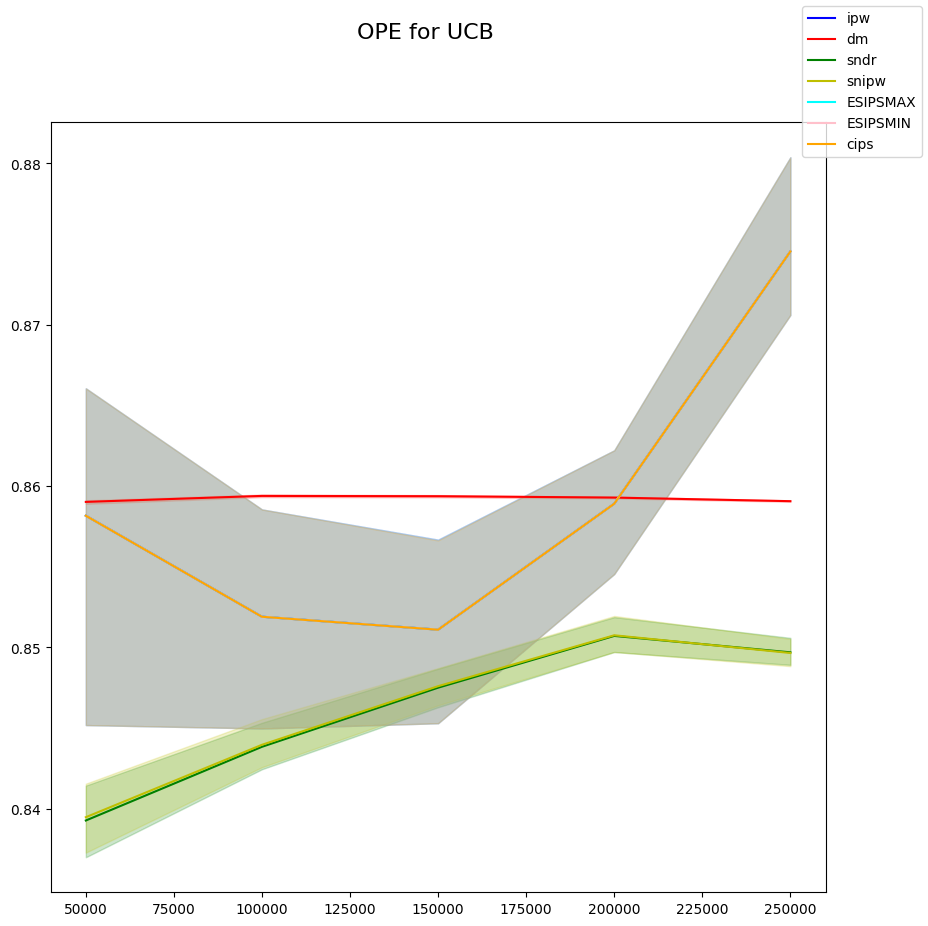

In [45]:
plot_join_res(ucb_v, ucb_ci, 'UCB')

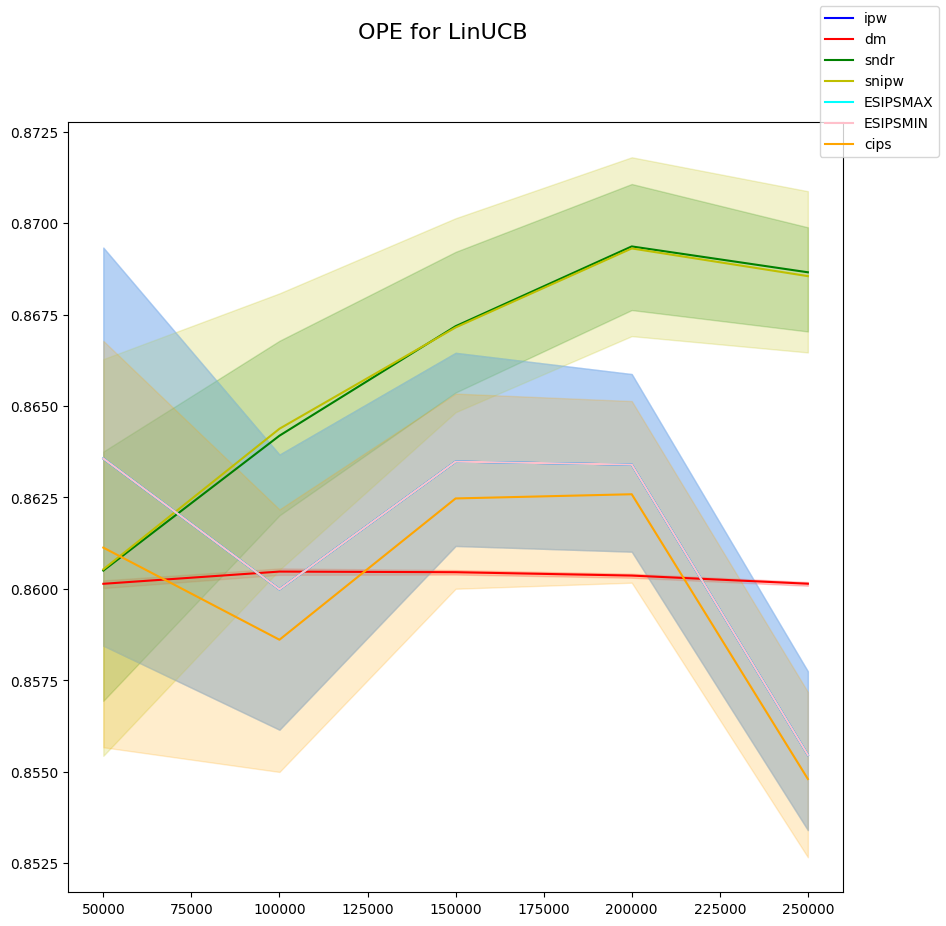

In [36]:
plot_join_res(linucb_v, linucb_ci, 'LinUCB')

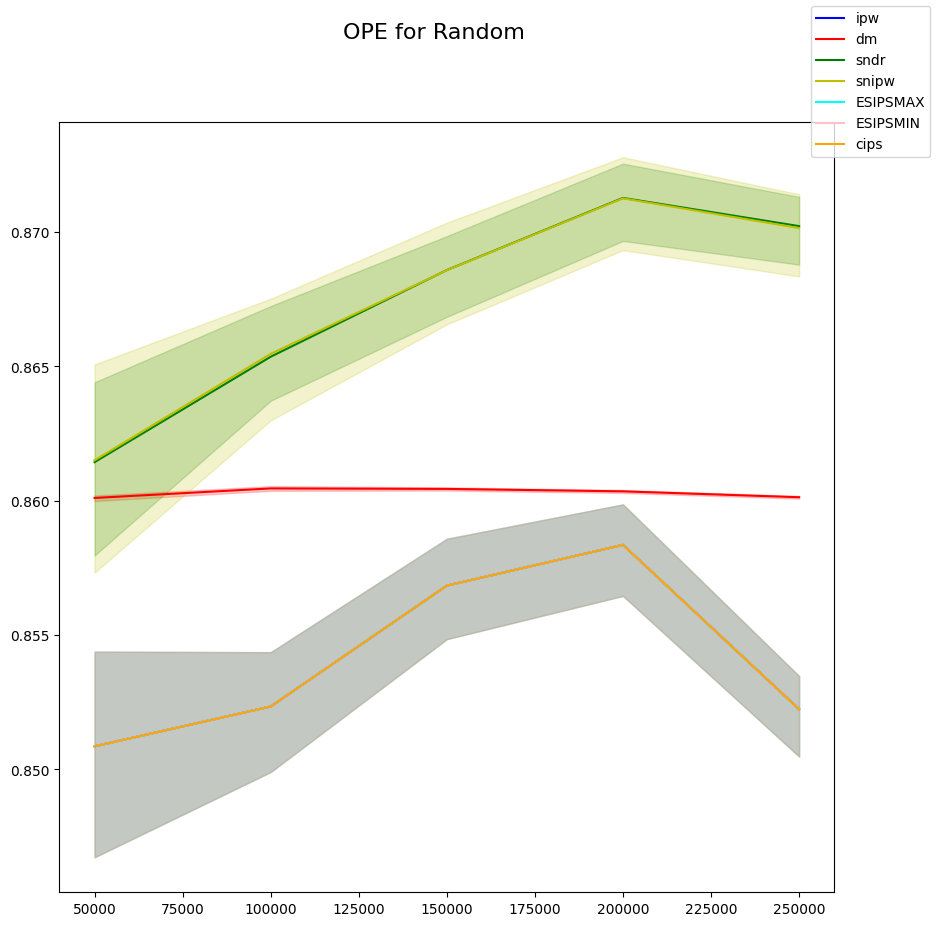

In [47]:
plot_join_res(random_v, random_ci, 'Random')

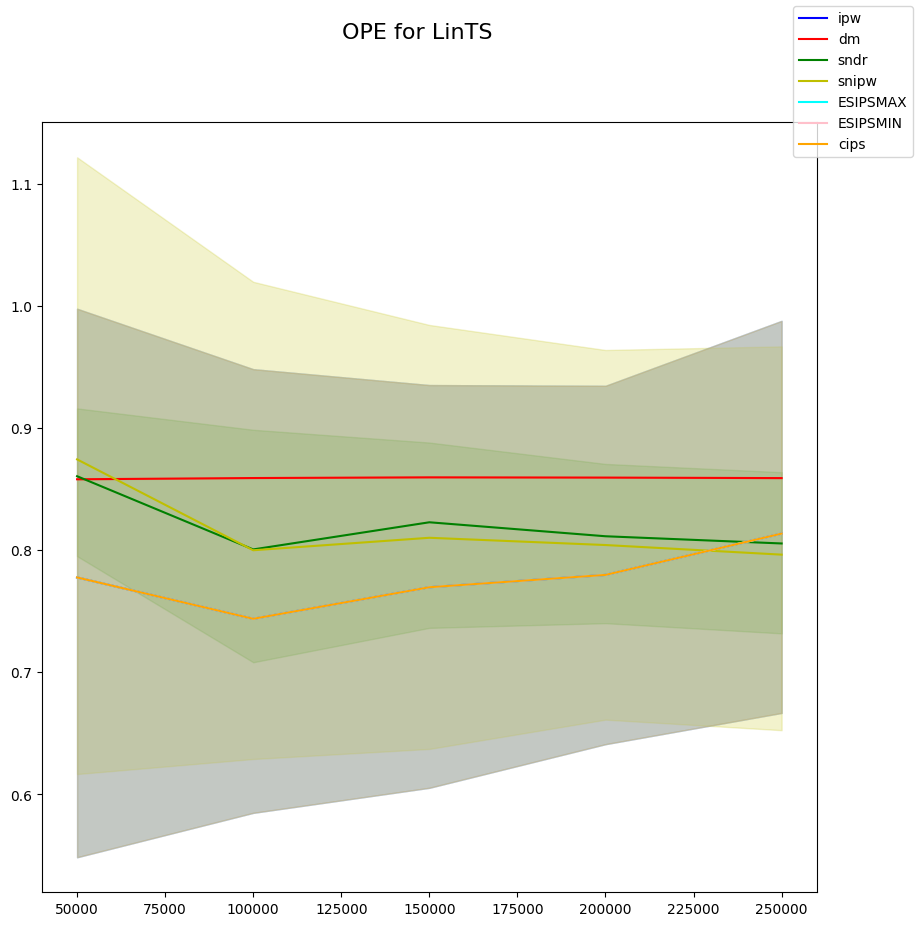

In [48]:
plot_join_res(lints_v, lints_ci, 'LinTS')

In [49]:
print("Estimated values USB")
print(ucb_v[-1])
print("Estimated values Lin USB")
print(linucb_v[-1])
print("Estimated values Random")
print(random_v[-1])
print("Estimated values LinTS")
print(lints_v[-1])

print("Estimated confidence intervals UCB:")
print(pd.DataFrame(ucb_ci[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(linucb_ci[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(random_ci[-1]).to_string())
print("Estimated confidence intervals LinTS:")
print(pd.DataFrame(lints_ci[-1]).to_string())

Estimated values USB
{'ipw': 0.8554971583080001, 'dm': 0.8590631411298472, 'sndr': 0.8396589967253302, 'snipw': 0.8396372264173048, 'ESIPSMAX': 0.8554971583080001, 'ESIPSMIN': 0.8554971583080001, 'cips': 0.8554971583080001}
Estimated values Lin USB
{'ipw': 0.9040775354758178, 'dm': 0.9065918149592272, 'sndr': 0.9055306573112463, 'snipw': 0.905389119054321, 'ESIPSMAX': 0.9040775354758178, 'ESIPSMIN': 0.9040775354758178, 'cips': 0.9039677445414737}
Estimated values Random
{'ipw': 0.8522387088953949, 'dm': 0.8601257803901408, 'sndr': 0.8701962930595905, 'snipw': 0.8701423663664696, 'ESIPSMAX': 0.8522387088953949, 'ESIPSMIN': 0.8522387088953949, 'cips': 0.8522365648662271}
Estimated values LinTS
{'ipw': 0.8232426039466626, 'dm': 0.8589117655330732, 'sndr': 0.8047594202102524, 'snipw': 0.805782300400707, 'ESIPSMAX': 0.8232426039466626, 'ESIPSMIN': 0.8232426039466626, 'cips': 0.8232426039466626}
Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw  ESI

In [33]:
# # n_negatives = [0, 50, 100, 150, 200, 250, 300, 350, 400]
# n_negatives = [250]

# for n_neg in n_negatives:
#     print('n_neg:', n_neg)
#     print(1, 'momory usage:', psutil.virtual_memory().percent)
#     bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True, n_neg=n_neg)
#     print(2, 'momory usage:', psutil.virtual_memory().percent)
        
#     model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
#     learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                         replay_model=model_2)
#     learner_2.fit(bandit_feedback_train)
#     print(3, 'momory usage:', psutil.virtual_memory().percent)
    
#     # learner_action_dist_2 = get_dist(learner_2)
    
#     # np.save(f'./Vs_CIs/learner_action_dist_2_{n_neg}.npy', learner_action_dist_2)
#     learner_action_dist_2 = np.load(f'./Vs_CIs/learner_action_dist_2_{n_neg}.npy')
    
#     print(4, 'momory usage:', psutil.virtual_memory().percent)
    
#     opt_params_ips_2 = optimize_ope_parameters(learner_action_dist_2, dict_opt_algo['Lin-UCB']['lambda_s'], dict_opt_algo['Lin-UCB']['beta_1s'], dict_opt_algo['Lin-UCB']['beta_2s'])
#     print(opt_params_ips_2)
    
#     print(5, 'momory usage:', psutil.virtual_memory().percent)
    
#     Vs_2, CIs_2 = run_exp(learner_action_dist_2, opt_params_ips_2['lambda_'], opt_params_ips_2['beta_1'], opt_params_ips_2['beta_2'])
    
#     np.save(f'./Vs_CIs/Vs_2_opt_{n_neg}.npy', Vs_2)
#     np.save(f'./Vs_CIs/CIs_2_opt_{n_neg}.npy', CIs_2)
#     print('Vs:', Vs_2[-1])
#     print('CIs:', CIs_2[-1])

In [37]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('UCB')
learner_1.fit(bandit_feedback_train)

print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 53.1
UCB


100%|██████████| 229/229 [00:57<00:00,  4.01it/s]                               


{'hr@1': 0.00042192209446822136, 'mrr@1': 0.00042192209446822136, 'ndcg@1': 0.00042192209446822136, 'cov@1': 0.004666666666666667}


100%|██████████| 229/229 [00:54<00:00,  4.20it/s]


{'hr@3': 0.0016914870265592335, 'mrr@3': 0.0009252269854602146, 'ndcg@3': 0.0011196424252037924, 'cov@3': 0.011333333333333334}


100%|██████████| 229/229 [00:54<00:00,  4.18it/s]


{'hr@10': 0.007122691956198781, 'mrr@10': 0.0019476041120384826, 'ndcg@10': 0.0031487060500188825, 'cov@10': 0.034666666666666665}


In [38]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('LinUCB')
learner_2.fit(bandit_feedback_train)

print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 74.6
LinUCB


100%|██████████| 229/229 [00:26<00:00,  8.77it/s]


{'hr@1': 0.009680566667821595, 'mrr@1': 0.009680566667821595, 'ndcg@1': 0.009680566667821595, 'cov@1': 0.048}


100%|██████████| 229/229 [00:26<00:00,  8.73it/s]


{'hr@3': 0.024055972694867485, 'mrr@3': 0.015828069372663667, 'ndcg@3': 0.017933279029472064, 'cov@3': 0.08733333333333333}


100%|██████████| 229/229 [00:26<00:00,  8.69it/s]


{'hr@10': 0.06206915447810427, 'mrr@10': 0.021904305003727365, 'ndcg@10': 0.03115547097218819, 'cov@10': 0.17066666666666666}


In [39]:
print('momory usage:', psutil.virtual_memory().percent)

print('Random')
learner_3.fit(bandit_feedback_train)

print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 65.4
Random


100%|██████████| 229/229 [00:54<00:00,  4.19it/s]


{'hr@1': 0.0006666385397380184, 'mrr@1': 0.0006666385397380184, 'ndcg@1': 0.0006666385397380184, 'cov@1': 0.818}


100%|██████████| 229/229 [00:54<00:00,  4.23it/s]


{'hr@3': 0.0019095476443250893, 'mrr@3': 0.0011841817911899702, 'ndcg@3': 0.001369196388731991, 'cov@3': 0.9913333333333333}


100%|██████████| 229/229 [00:54<00:00,  4.24it/s]


{'hr@10': 0.0072211477445680485, 'mrr@10': 0.0019945451281279344, 'ndcg@10': 0.0031804203059038858, 'cov@10': 1.0}


In [40]:
print('momory usage:', psutil.virtual_memory().percent)
    
print('LinTS')
learner_4.fit(bandit_feedback_train)

print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 10))

momory usage: 76.5
LinTS


100%|██████████| 229/229 [01:39<00:00,  2.29it/s]


{'hr@1': 0.0005809443732582917, 'mrr@1': 0.0005809443732582917, 'ndcg@1': 0.0005809443732582917, 'cov@1': 0.2693333333333333}


100%|██████████| 229/229 [01:40<00:00,  2.27it/s]


{'hr@3': 0.0016687193135554814, 'mrr@3': 0.0009377551161915929, 'ndcg@3': 0.0011230816085633288, 'cov@3': 0.31266666666666665}


100%|██████████| 229/229 [01:40<00:00,  2.27it/s]


{'hr@10': 0.004609327271982165, 'mrr@10': 0.0012551300714850227, 'ndcg@10': 0.002018784475954638, 'cov@10': 0.5313333333333333}
